## Знакомство с рабочим пространством PyTorch

In [1]:
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch import optim

### Разбиение данных для обучения

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |


In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(7, 5))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});

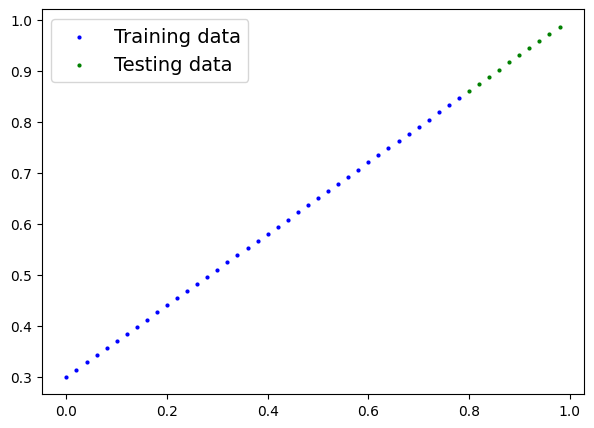

In [5]:
plot_predictions()

### Линейная регрессия

#### Архитектура нейросети

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |


In [38]:
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32),  # начинаем со случайный весов
                                    requires_grad=True)  # для автоматического подсчета градиентов
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32), 
                                 requires_grad=True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias  # по формуле линейной регрессии

In [39]:
torch.manual_seed(42)

model0 = LinearRegressionModel()
list(model0.parameters())  # нужно обернуть, тк возвращается генератор

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [40]:
model0.state_dict()  # другой способ получить параметры нейросети

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Предикты необученной модели

In [41]:
# нужно чтобы во время предикта не считались градиенты; ускоряет процесс предикта
with torch.no_grad():
    y_preds = model0(X_test)

In [42]:
with torch.inference_mode():  # то же самое, что и пример выше (но более рекомендуемо, свежее, быстрее)
    y_preds = model0(X_test)

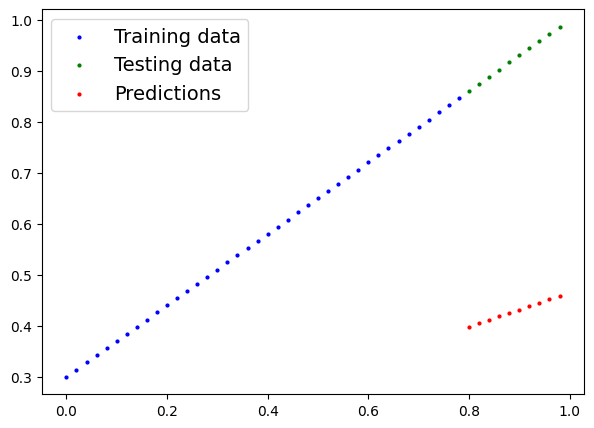

In [43]:
plot_predictions(predictions=y_preds)

Следовательно, необученная модель плохо предсказывает

#### Обучение нейросети

For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb: 
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* computing the gradients of the loss with respect to every model parameter (`loss.backward()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

In [44]:
loss_fn = nn.L1Loss()
optimizer = optim.SGD(params=model0.parameters(),  # параметры модели, которые нужно оптимизировать
                      lr=0.01)  # шаг сходимости

In [45]:
torch.manual_seed(42)

epochs = 200

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    '''Обучение'''

    model0.train()  # переводим в режим обучения
    # 1. Прямой проход через НС. forward()
    y_pred = model0(X_train)
    # 2. Вычисление функции потерь для алгоритма обратного распространения (back propagation)
    loss = loss_fn(y_pred, y_train)
    # 3. Установка нулевых локальных градиентов (чтобы они не накапливались)
    optimizer.zero_grad()
    # 4. Вычисление градиентов потерь по всем параметрам модели (подсчет локальных градиентов)
    loss.backward()
    # 5. Корректировка весов с помощью оптимизатора
    optimizer.step()

    '''Тестирование'''

    model0.eval()  # переводим в режим отладки

    with torch.inference_mode():
        # 1. Получение предсказаний
        test_pred = model0(X_test)
        # 2. Вычисление функции потерь
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # вывод информации по процессу обучения
    if epoch % 10 == 0:  # выводим информацию каждую 10 эпоху обучения
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())  # detach() копирует данные из тензора, но без использования градиента
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

#### Оценка обучения

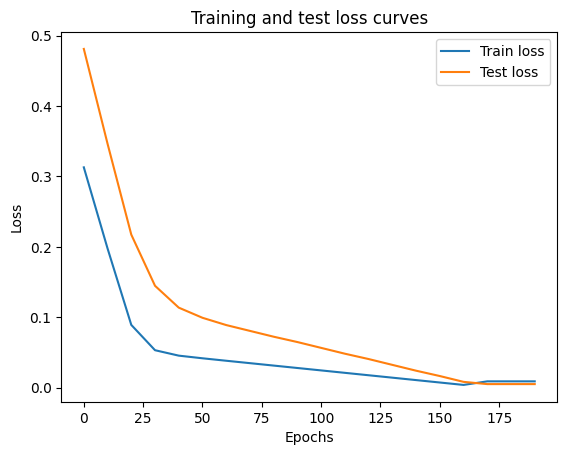

In [46]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [47]:
print("The model learned the following values for weights and bias:")
print(model0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [48]:
model0.eval()
with torch.inference_mode():
    y_pred = model0(X_test)

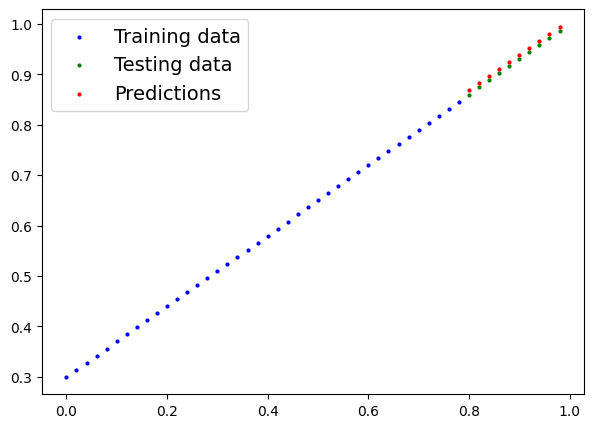

In [49]:
plot_predictions(predictions=y_pred)

Нейронка научилась предсказывать намного лучше, чем в необученном виде